In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt

## Parsing data set breeds

In [2]:
attr = pd.read_csv('attributes.csv',index_col=0)

In [3]:
breeds = []
for index, row in attr.iterrows():
    # Converting to lower case
    breed = row['breed'].lower()
    
    # Replacing characters
    breed = breed.replace('mixed','')
    breed = breed.replace('breed','')
    breed = breed.replace('mix','')
    breed = breed.replace('dog','')
    breed = breed.replace('/','')
    
#     # Splitting into list
    breed = breed.split('&')
    
    for i in range(0,len(breed)):
        breed[i] = breed[i].split(' ')
        
        breed[i] = [word for word in breed[i] if word != '']
        
        breed[i] = set(breed[i])

        
    breeds.append(breed)
    
#     break

In [4]:
attr['breedsParsed'] = breeds

In [5]:
# Removing dogs with no breed information
attr = attr[attr['breedsParsed'].apply(lambda breeds: len(breeds[0]) >= 1)]

In [6]:
# Exploding by breed
attr = attr[['path','breedsParsed']].explode('breedsParsed')

## Parsing True Breeds

In [7]:
import scipy.io

In [8]:
mat = scipy.io.loadmat('file_list.mat')

In [9]:
breeds = set()
for file in mat['file_list']:
    # Getting the contents of the array
    fileContents = file[0][0]
    
    # Getting rid of the file name
    subContents = fileContents[10:]
    
    # Finding the slash to use as separator
    slashLoc = subContents.find('/')
    
    # Extracting the breed
    breed = subContents[0:slashLoc]

    # Normizling Breed:
    
    # to all lower case
    breed = breed.lower()
    
    # splitting the breed unto mutiple strings
    breed = breed.split('_')
    
    # Adding breed to list
    breeds.add(tuple(breed))


In [10]:
# Converting back to list
breeds = list(breeds)

In [11]:
# Converting breeds to set
breeds = [set(i) for i in breeds]

## Similarity

In [12]:
# Computing the cross product
crossProduct = list(itertools.product(attr.values.tolist(), breeds))

In [13]:
# Converting to df
crossProductDF = pd.DataFrame(crossProduct, columns=['dogBreed', 'breed'])

In [14]:
def jaccard(dogBreed, breed):
    intersection = len(dogBreed.intersection(breed))
    
    union = len(dogBreed.union(breed))
    
    return intersection / union

In [15]:
ious = []
for index, row in crossProductDF.iterrows():
    iou = jaccard(row['dogBreed'][1], row['breed'])
    
    ious.append(iou)
    
    if index % 5000 == 0:
        print(f"{round((index / len(crossProductDF)) * 100, 3)} %")
    

0.0 %
0.404 %
0.808 %
1.211 %
1.615 %
2.019 %
2.423 %
2.827 %
3.23 %
3.634 %
4.038 %
4.442 %
4.845 %
5.249 %
5.653 %
6.057 %
6.461 %
6.864 %
7.268 %
7.672 %
8.076 %
8.48 %
8.883 %
9.287 %
9.691 %
10.095 %
10.498 %
10.902 %
11.306 %
11.71 %
12.114 %
12.517 %
12.921 %
13.325 %
13.729 %
14.133 %
14.536 %
14.94 %
15.344 %
15.748 %
16.151 %
16.555 %
16.959 %
17.363 %
17.767 %
18.17 %
18.574 %
18.978 %
19.382 %
19.786 %
20.189 %
20.593 %
20.997 %
21.401 %
21.804 %
22.208 %
22.612 %
23.016 %
23.42 %
23.823 %
24.227 %
24.631 %
25.035 %
25.439 %
25.842 %
26.246 %
26.65 %
27.054 %
27.457 %
27.861 %
28.265 %
28.669 %
29.073 %
29.476 %
29.88 %
30.284 %
30.688 %
31.092 %
31.495 %
31.899 %
32.303 %
32.707 %
33.11 %
33.514 %
33.918 %
34.322 %
34.726 %
35.129 %
35.533 %
35.937 %
36.341 %
36.745 %
37.148 %
37.552 %
37.956 %
38.36 %
38.763 %
39.167 %
39.571 %
39.975 %
40.379 %
40.782 %
41.186 %
41.59 %
41.994 %
42.398 %
42.801 %
43.205 %
43.609 %
44.013 %
44.416 %
44.82 %
45.224 %
45.628 %
46.032 %
46.4

In [16]:
# Adding the IOUS
crossProductDF['iou'] = ious

In [17]:
# Removing bad IOUS
crossProductDF = crossProductDF[crossProductDF['iou'] >= 0.75]

In [19]:
# Converting breed to string to get counts
crossProductDF['breedString'] = crossProductDF.apply(lambda row: str(row['breed']),axis=1)

In [20]:
# Computing the counts for each bread
countsDF = pd.DataFrame(crossProductDF.groupby(['breedString']).size(),columns=['count'])

In [21]:
# Getting the breeds with only 1 dog
badBreeds = countsDF[countsDF['count'] <= 1].index.values

In [22]:
# Filtering at dogs that are the only 1 of their breeds
crossProductDF = crossProductDF[crossProductDF.apply(lambda row: row['breedString'] not in badBreeds, axis=1)]

In [23]:
# Expanding dog column into 2 columns
crossProductDF = pd.merge(
    crossProductDF, 
    pd.DataFrame(
        crossProductDF['dogBreed'].values.tolist(), columns=['path','dogBreed']
    ),
    on=crossProductDF.index
)

In [24]:
# Droppign useless columns
crossProductDF = crossProductDF.drop(['dogBreed_x','key_0'],axis=1)

In [25]:
# Renaming column
crossProductDF = crossProductDF.rename({'dogBreed_y':'dogBreed'},axis=1)

## Formatting Output

In [26]:
# Reading in the attributes again to get the splits
attrAgain = pd.read_csv('attributes.csv',index_col=0)

In [27]:
# Subsetting to only the columns we need
attrAgain = attrAgain[['path','type','cleanImages']]

In [28]:
# Getting the data type
attributes_breed = pd.merge(crossProductDF[['path']].drop_duplicates(), attrAgain)

In [29]:
# Writing to disk
attributes_breed.to_csv('attributes_breed.csv')

In [30]:
crossProductDF.drop(['dogBreed','breed','iou'],axis=1).drop_duplicates().to_csv('breeds.csv')

## Vizualizing Results

In [2]:
breeds = pd.read_csv('breeds.csv',index_col=0)

In [8]:
breeds.groupby('breedString').size().sort_values()

breedString
{'poodle', 'standard'}                        2
{'papillon'}                                  2
{'flat-coated', 'retriever'}                  2
{'west', 'white', 'highland', 'terrier'}      2
{'schipperke'}                                3
{'setter', 'english'}                         3
{'schnauzer', 'miniature'}                    3
{'australian', 'terrier'}                     3
{'samoyed'}                                   4
{'keeshond'}                                  4
{'elkhound', 'norwegian'}                     4
{'newfoundland'}                              5
{'basenji'}                                   5
{'border', 'terrier'}                         5
{'brittany', 'spaniel'}                       6
{'italian', 'greyhound'}                      6
{'saluki'}                                    6
{'wolfhound', 'irish'}                        7
{'bloodhound'}                                7
{'affenpinscher'}                            10
{'weimaraner'}              

In [4]:
breeds['breeds'] = breeds['breedString'].apply(lambda x: [str(i) for i in eval(x)]).apply(lambda x: " ".join(x))

In [5]:
breedCount = pd.DataFrame(breeds.groupby('breeds').size()).reset_index()

In [37]:
breedCount['percent'] = breedCount[0] / breedCount[0].sum()

In [44]:
topThree = breedCount.sort_values('percent',ascending=False).iloc[0:3,]

In [45]:
bottomThree = breedCount.sort_values('percent',ascending=False).iloc[-3:,]

In [59]:
both = topThree.append(bottomThree)

/tmp/ipykernel_928/3381557010.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  both = topThree.append(bottomThree)


/tmp/ipykernel_928/1964123681.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  bars = ax.barh(both['breeds'],


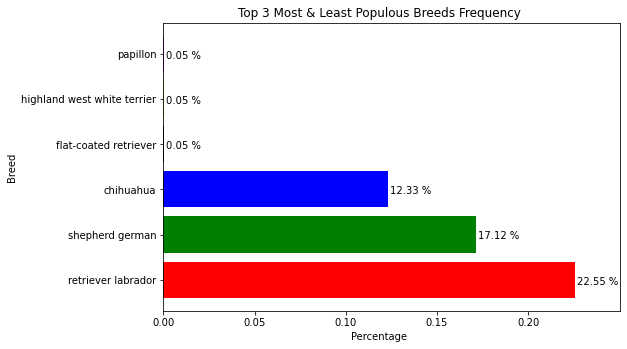

In [146]:
fig = plt.figure()

ax = fig.add_axes((0, 0, 1, 1))



bars = ax.barh(both['breeds'], 
        both['percent'], color='rgbkymc')
# plt.xticks(rotation=40)
plt.ylabel('Breed')
plt.xlabel('Percentage')
plt.title('Top 3 Most & Least Populous Breeds Frequency')
i = 0
for bar in bars:
    yval = bar.get_height()
    
    val = both['percent'].values[i]
    
    val = round(round(val, 4) * 100, 4)
    
    plt.text(bar.get_width() + .001, bar.get_y()+0.3, str(val) + ' %')
    
    i += 1
ax.spines["right"].set_position(("outward", 25))

ax.spines["top"].set_bounds(0, 0.25)

ax.spines['bottom'].set_bounds(0, 0.25)

plt.savefig('breed_distr.png')
# plt.show()